In [342]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ilpd-final-project/ilpd.csv


## import library

In [343]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score

from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## read data

In [344]:
df = pd.read_csv('/kaggle/input/ilpd-final-project/ilpd.csv')
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


## data understanding

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [346]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [347]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.00,58.0,90.0
Total_Bilirubin,583.0,3.298799,6.209522,0.4,0.8,1.00,2.6,75.0
Direct_Bilirubin,583.0,1.486106,2.808498,0.1,0.2,0.30,1.3,19.7
Alkaline_Phosphotase,583.0,290.576329,242.937989,63.0,175.5,208.00,298.0,2110.0
Alamine_Aminotransferase,583.0,80.713551,182.620356,10.0,23.0,35.00,60.5,2000.0
Aspartate_Aminotransferase,583.0,109.910806,288.918529,10.0,25.0,42.00,87.0,4929.0
Total_Protiens,583.0,6.483190,1.085451,2.7,5.8,6.60,7.2,9.6
Albumin,583.0,3.141852,0.795519,0.9,2.6,3.10,3.8,5.5
Albumin_and_Globulin_Ratio,579.0,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8
Dataset,583.0,1.286449,0.452490,1.0,1.0,1.00,2.0,2.0


## eda & preprocessing

## outlier handling

In [348]:
df.shape

(583, 11)

In [349]:
# def drop_outliers_iqr_all_columns(df, exclude_column):
#     df_clean = df.copy()
#     for column in df.columns:
#         if column == exclude_column:
#             continue
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         df_clean = df_clean[~((df_clean[column] < lower_bound) | (df_clean[column] > upper_bound))]
        
#     return df_clean

# df = drop_outliers_iqr_all_columns(df, exclude_column='Gender')

**dropping outlier mengurangi akurasi secara signifikan**

In [350]:
df.shape

(583, 11)

### encoding

In [351]:
df.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [352]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

**data sudah dilakukan labelling pada kolom gender.**

## missing value handling

In [353]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [354]:
df = df.dropna()

df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

**missing value sudah dihilangkan menggunakan metode dropping.**

## scaling

In [355]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [356]:
scaler = MinMaxScaler()
features = df.drop(['Dataset'], axis=1).columns

df[features] = scaler.fit_transform(df[features])

df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,0.709302,0.0,0.004021,0.000000,0.060576,0.003015,0.001626,0.594203,0.521739,0.240,1
1,0.674419,1.0,0.140751,0.275510,0.310699,0.027136,0.018296,0.695652,0.500000,0.176,1
2,0.674419,1.0,0.092493,0.204082,0.208598,0.025126,0.011791,0.623188,0.521739,0.236,1
3,0.627907,1.0,0.008043,0.015306,0.058134,0.002010,0.002033,0.594203,0.543478,0.280,1
4,0.790698,1.0,0.046917,0.096939,0.064485,0.008543,0.009961,0.666667,0.326087,0.040,1


**scalling dilakukan pada semua kolom menggunakan min-max scaling**

## class distribution

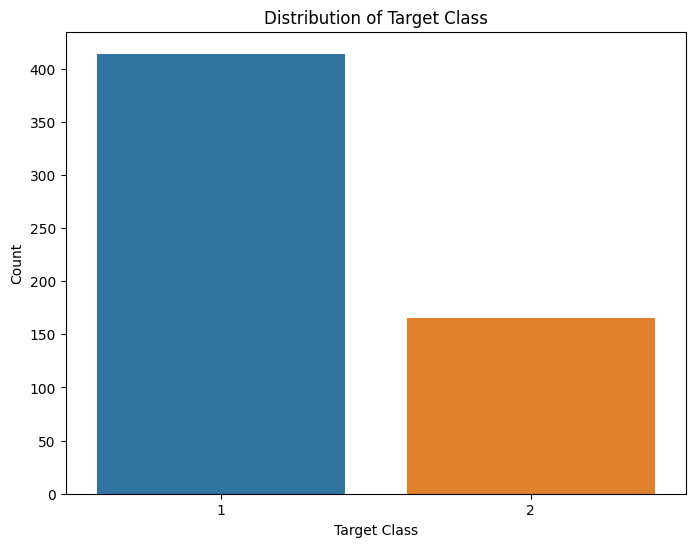

In [357]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Dataset', data=df)
plt.title('Distribution of Target Class')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

**This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from test samples in North East of Andhra Pradesh, India. 'is_patient' is a class label used to divide into groups(liver patient or not). This data set contains 441 male patient records and 142 female patient records.**

In [358]:
df['Dataset'] = df['Dataset'].map({1: 1, 2: 0})

**mengubah label yang memiliki nilai 1 menjadi 1 dan yang memiliki nilai 2 menjadi 0**

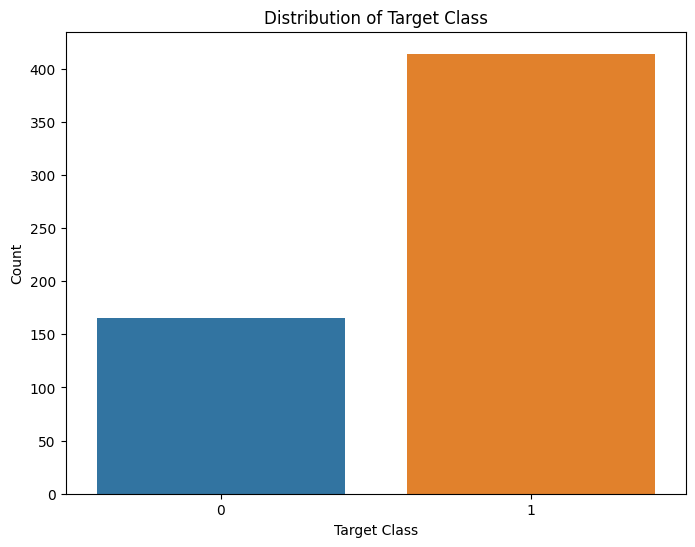

In [359]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Dataset', data=df)
plt.title('Distribution of Target Class')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

**data terlihat imbalance, perlu dilakukan balancing**

## feature correlation

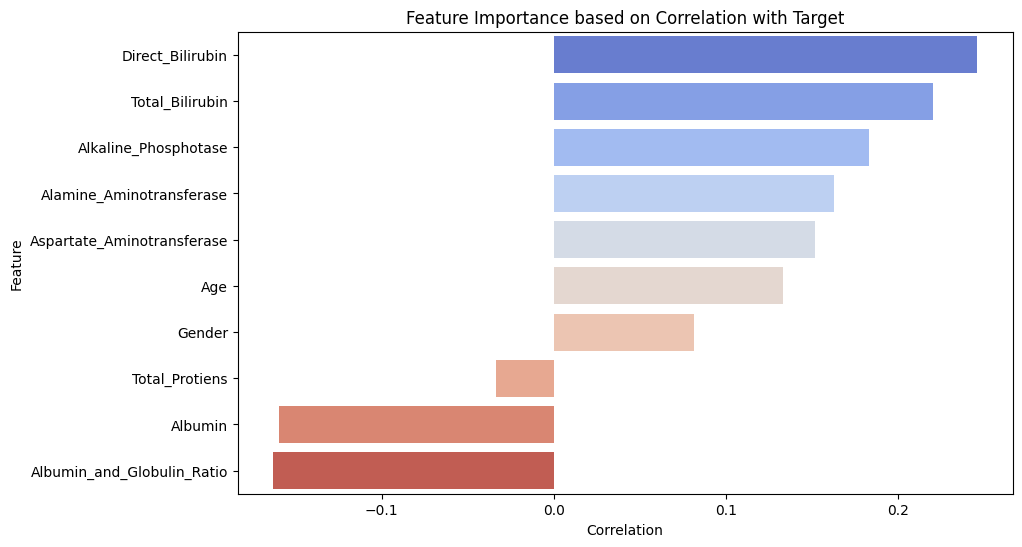

In [360]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Heatmap of Imputed Dataset')
# plt.show()

# Menghitung korelasi antara setiap kolom dan target
correlations = df.corr()['Dataset'].drop('Dataset')

# Membuat DataFrame dari hasil korelasi
correlation_df = pd.DataFrame(correlations).reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Sortir berdasarkan nilai korelasi
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Membuat visualisasi bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=correlation_df, palette='coolwarm')
plt.title('Feature Importance based on Correlation with Target')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()

In [361]:
plt.savefig('heatmap_imputed_dataset.png', format='png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [362]:
# Menghitung korelasi antara setiap kolom dan target
correlations = df.corr()['Dataset'].drop('Dataset')

# Membuat DataFrame dari hasil korelasi
correlation_df = pd.DataFrame(correlations).reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Sortir berdasarkan nilai korelasi
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

# Membuat tabel fitur dan nilai korelasi
features_table = correlation_df['Feature']
correlations_table = correlation_df['Correlation']

# Tampilkan tabel fitur dan nilai korelasi
print("Features Table:")
print(features_table)

print("\nCorrelations Table:")
print(correlations_table)

Features Table:
3              Direct_Bilirubin
2               Total_Bilirubin
4          Alkaline_Phosphotase
5      Alamine_Aminotransferase
6    Aspartate_Aminotransferase
0                           Age
1                        Gender
7                Total_Protiens
8                       Albumin
9    Albumin_and_Globulin_Ratio
Name: Feature, dtype: object

Correlations Table:
3    0.246273
2    0.220218
4    0.183363
5    0.163117
6    0.151834
0    0.133164
1    0.081349
7   -0.033614
8   -0.159770
9   -0.163131
Name: Correlation, dtype: float64


## violin plot

## modelling

In [363]:
X = df.drop('Dataset', axis=1)
y = df['Dataset']

smote_nc = SMOTENC(categorical_features=[1], random_state=42)

X_resampled, y_resampled = smote_nc.fit_resample(X, y)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

print("Class Distribution after Oversampling:")
print(Counter(df_resampled['Dataset']))

Class Distribution after Oversampling:
Counter({1: 414, 0: 414})


In [364]:
# Daftar model base
base_models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'LGBMClassifier': LGBMClassifier(verbosity=-1),
    'SVC': SVC(verbose=0),
    'XGBClassifier': XGBClassifier(verbosity=0),
    'RandomForestClassifier': RandomForestClassifier(),
    'CatBoostClassifier': CatBoostClassifier(verbose=0),
    'LogisticRegression': LogisticRegression()
}

# Inisialisasi k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary untuk menyimpan hasil akurasi
accuracy_scores = {}

# Lakukan cross-validation dan hitung akurasi untuk setiap model
for model_name, model in base_models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')
    accuracy_scores[model_name] = scores.mean()
    print(f"{model_name} Accuracy: {scores.mean()}")

KNeighborsClassifier Accuracy: 0.7040111666176903
GaussianNB Accuracy: 0.6847193652659417
LGBMClassifier Accuracy: 0.8249191889509258
SVC Accuracy: 0.6859388774610637
XGBClassifier Accuracy: 0.820129297678519
RandomForestClassifier Accuracy: 0.8236555980017632
CatBoostClassifier Accuracy: 0.80797825448134
LogisticRegression Accuracy: 0.7016309138995005


In [365]:
# Inisialisasi model-model base dengan verbose=0
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
lgbm_model = LGBMClassifier(verbosity=-1)
svm_model = SVC(verbose=0)
xgb_model = XGBClassifier(verbosity=0)
rf_model = RandomForestClassifier()
catboost_model = CatBoostClassifier(verbose=0)

# Inisialisasi meta model
lr_model = LogisticRegression()

# Definisikan stacking classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('knn', knn_model),
        ('nb', nb_model),
        ('lgbm', lgbm_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('catboost', catboost_model)
    ],
    final_estimator=lr_model
)

# Initialize k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

# Perform k-fold cross-validation and get accuracy scores
scores = cross_val_score(stacking_classifier, X_resampled, y_resampled, cv=kfold)

# Print the accuracy scores
print("Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Accuracy Scores: [0.80722892 0.75903614 0.89156627 0.8313253  0.8313253  0.79518072
 0.84337349 0.80722892 0.82926829 0.8902439 ]
Mean Accuracy: 0.8285777255362914
